# Investigating the impact of moderator interventions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tasks.stats
import tasks.postprocessing
import tasks.graphs

In [2]:
sns.set(style="whitegrid")

In [3]:
from tasks.constants import *


TOXICITY_TICKS = np.arange(1, 6, 1)
YTICKS_LIST = [TOXICITY_TICKS, TOXICITY_TICKS]
VMIN_TOXICITY = -1
VMAX_TOXICITY = 1

## Preprocessing

In [4]:
full_df = tasks.postprocessing.get_main_dataset()
full_df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened
0,75173c9d-9d25-4389-93d9-6fd7978e30b8,553054330741756452,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",2,4,False
1,75173c9d-9d25-4389-93d9-6fd7978e30b8,553054330741756452,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",4,5,False
2,75173c9d-9d25-4389-93d9-6fd7978e30b8,553054330741756452,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",3,4,False
3,75173c9d-9d25-4389-93d9-6fd7978e30b8,553054330741756452,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",3,4,False
4,75173c9d-9d25-4389-93d9-6fd7978e30b8,553054330741756452,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",4,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51310,8e301e72-344d-4331-89bc-4dc1edca20fe,1737594611854314181,21,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
51311,8e301e72-344d-4331-89bc-4dc1edca20fe,1737594611854314181,21,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
51312,8e301e72-344d-4331-89bc-4dc1edca20fe,1737594611854314181,21,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
51313,8e301e72-344d-4331-89bc-4dc1edca20fe,1737594611854314181,21,Human Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False


## When do moderators intervene?

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intervention_count.png


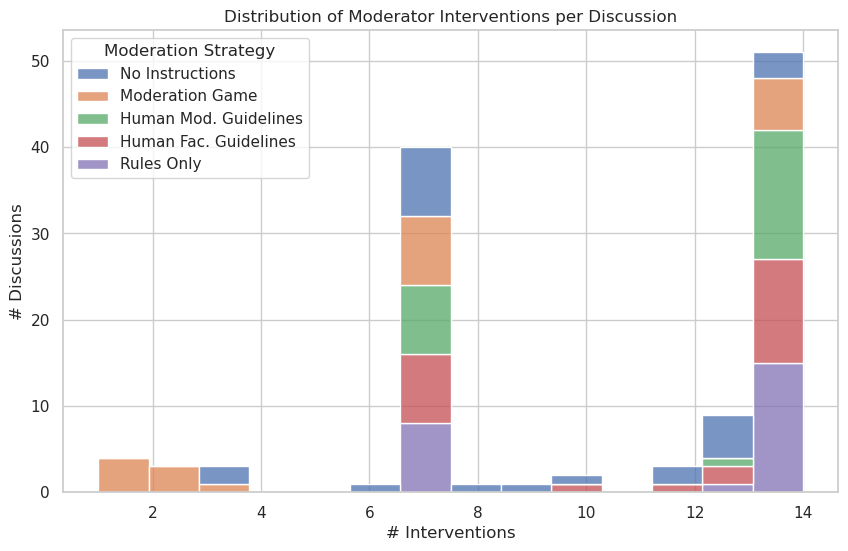

In [5]:
df_unique = full_df[full_df["conv_variant"] != "No Moderator"].drop_duplicates(
    subset=["message_id"]
)

# Compute number of moderator interventions per conversation
moderator_interventions = (
    df_unique[df_unique["is_moderator"]].groupby("conv_id").size()
)

# Merge with conversation variants
conv_variants = (
    df_unique[["conv_id", "conv_variant"]]
    .drop_duplicates()
    .set_index("conv_id")
)
moderator_interventions = moderator_interventions.to_frame(
    name="moderator_interventions"
).join(conv_variants, how="left")

plt.figure(figsize=(10, 6))
sns.histplot(
    data=moderator_interventions.rename(
        {"conv_variant": "Moderation Strategy"}, axis=1
    ),
    x="moderator_interventions",
    hue="Moderation Strategy",
    multiple="stack",
    bins=14,
)
plt.xlabel("# Interventions")
plt.ylabel("# Discussions")
plt.title("Distribution of Moderator Interventions per Discussion")

tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "intervention_count.png")
plt.show()

Draw red lines when the moderator does not intervene

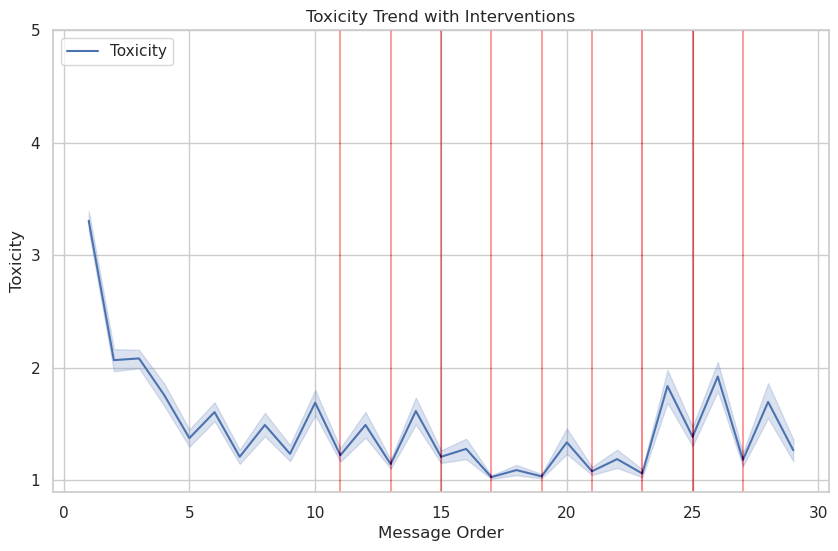

In [6]:
intervention_df = full_df[full_df.conv_variant == "No Instructions"]

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=intervention_df, x="message_order", y="Toxicity", label="Toxicity"
)

# Add vertical dashed red lines where not_intervened is True
for msg_order in intervention_df.loc[
    intervention_df["not_intervened"], "message_order"
]:
    plt.axvline(
        x=msg_order, color="red", linestyle="dashed", lw=0.02, alpha=0.2
    )

plt.xlabel("Message Order")
plt.ylabel("Toxicity")
plt.title("Toxicity Trend with Interventions")
plt.yticks(TOXICITY_TICKS)

plt.show()

Repeat for each individual discussion

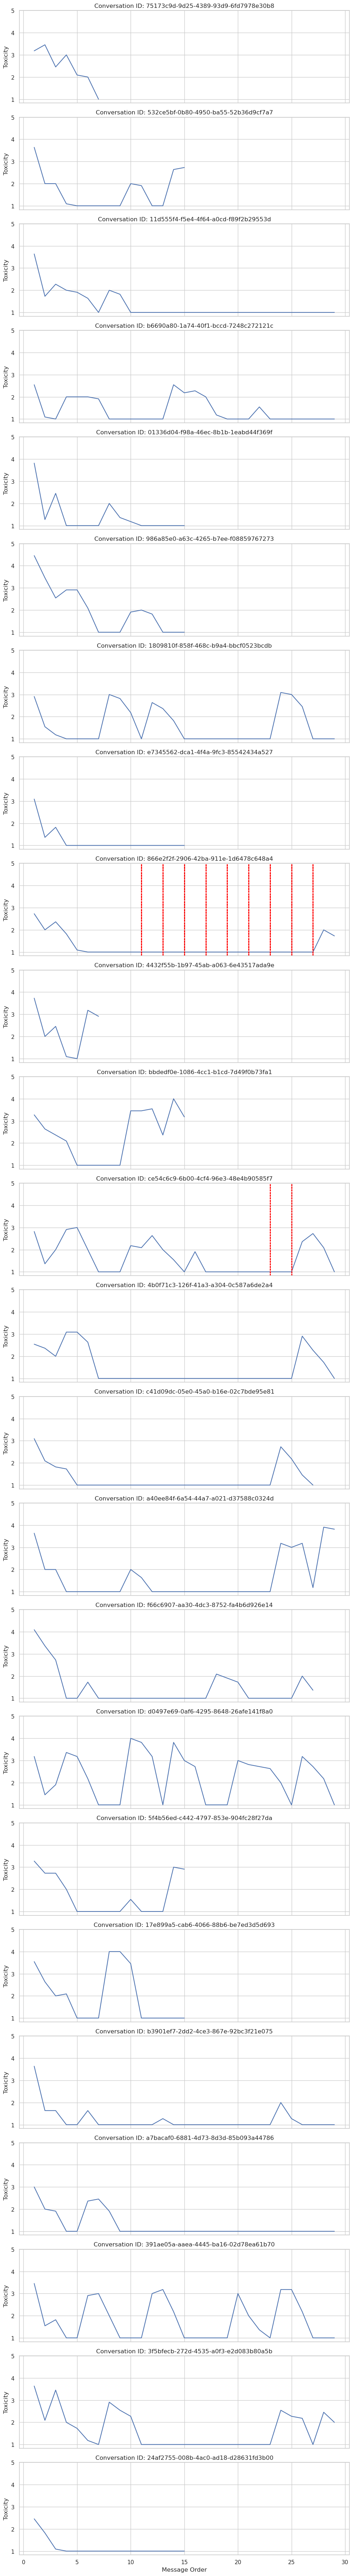

In [7]:
intervention_df = full_df[full_df.conv_variant == "No Instructions"]

# Create subplots (one for each conversation)
conv_ids = intervention_df.conv_id.unique()
fig, axes = plt.subplots(
    len(conv_ids), 1, figsize=(10, 3 * len(conv_ids)), sharex=True, sharey=True
)

if len(conv_ids) == 1:
    axes = [axes]

for ax, conv_id in zip(axes, conv_ids):
    local_df = intervention_df[intervention_df.conv_id == conv_id]

    # Lineplot for toxicity trend
    sns.lineplot(
        data=local_df, x="message_order", y="Toxicity", ax=ax, errorbar=None
    )

    # Add vertical dashed red lines for not_intervened points
    for msg_order in local_df.loc[local_df["not_intervened"], "message_order"]:
        ax.axvline(
            x=msg_order, color="red", linestyle="dashed", lw=1, alpha=0.5
        )

    ax.set_title(f"Conversation ID: {conv_id}")
    ax.set_ylabel("Toxicity")
    ax.set_yticks(TOXICITY_TICKS)


plt.xlabel("Message Order")
plt.tight_layout()
plt.show()

Non-interventions are an anomaly seen in mostly one discussion.

## Statistical Analysis

In [8]:
analysis_df = full_df.loc[
    (full_df.intent != "Moderator") & (full_df.model != "hardcoded")
]

### Moderation Strategy

#### Toxicity

In [9]:
tasks.stats.mean_comp_test(
    df=analysis_df, feature_col="conv_variant", score_col="Toxicity"
)

1.5219744575139888e-205

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/toxicity_stats.png


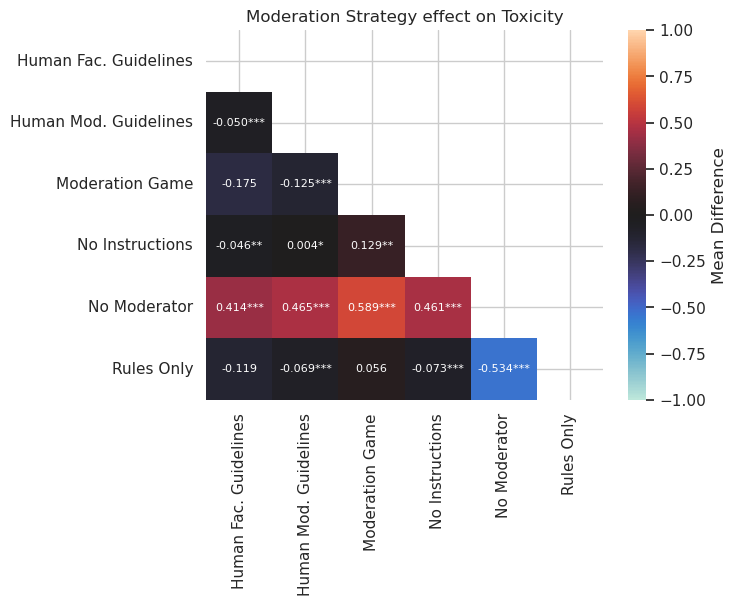

In [10]:
tasks.graphs.posthoc_heatmap(
    analysis_df,
    val_col="Toxicity",
    group_col="conv_variant",
    vmin=VMIN_TOXICITY,
    vmax=VMAX_TOXICITY,
)
plt.title("Moderation Strategy effect on Toxicity")

tasks.graphs.save_plot(GRAPH_OUTPUT_DIR / "toxicity_stats.png")
plt.show()

#### Argument Quality

In [11]:
tasks.stats.mean_comp_test(
    df=analysis_df, feature_col="conv_variant", score_col="Argument Quality"
)

1.0574096831588338e-46

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/argumentq_stats.png


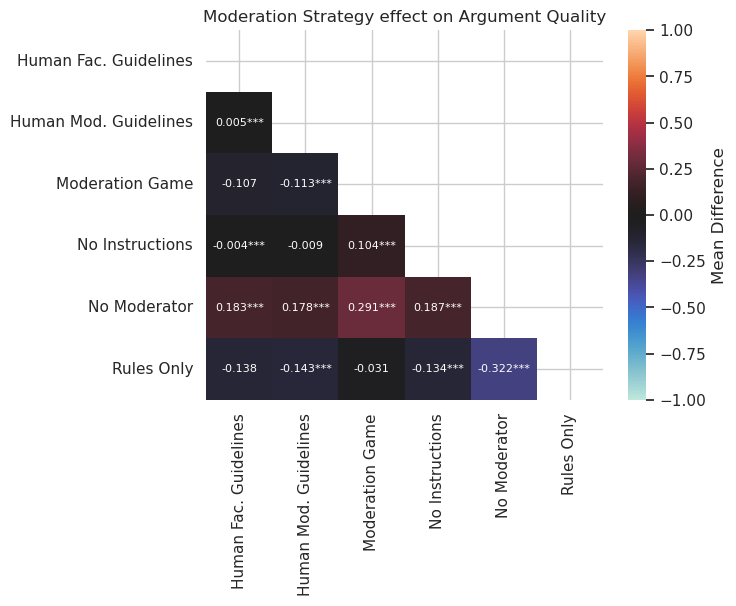

In [12]:
tasks.graphs.posthoc_heatmap(
    analysis_df,
    val_col="Argument Quality",
    group_col="conv_variant",
    vmin=VMIN_TOXICITY,
    vmax=VMAX_TOXICITY,
)
plt.title("Moderation Strategy effect on Argument Quality")

tasks.graphs.save_plot(GRAPH_OUTPUT_DIR / "argumentq_stats.png")
plt.show()